In [19]:
import sys
sys.path.append("../")

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
from neural_net.mlp import MLP
from neural_net.nn_utils import compute_jacobian
from models.hd_regression_model import HDRegressionModel
from models.ld_regression_model import LDRegressionModel
from sampling.least_squares_sampler import LeastSquaresSampler
from sampling.sghmc_sampling import SGHMCsampler
from sampling.rate_schedulers import *
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
data = fetch_california_housing()
X, y = data.data, data.target
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=1)
x_train_raw, x_val_raw, y_train_raw, y_val_raw = train_test_split(x_train_raw, y_train_raw, test_size=0.25, random_state=1)

d = x_train_raw.shape[-1]
n = x_train_raw.shape[0]

# normalize
scalerX = StandardScaler()
scalerX.fit(x_train_raw)
scalerY = StandardScaler()
scalerY.fit(y_train_raw.reshape(-1,1))
x_train = scalerX.transform(x_train_raw)
x_test = scalerX.transform(x_test_raw)
x_val = scalerX.transform(x_val_raw)
y_train = scalerY.transform(y_train_raw.reshape(-1,1))
y_test = scalerY.transform(y_test_raw.reshape(-1,1))
y_val = scalerY.transform(y_val_raw.reshape(-1,1))

# convert to pytorch format
x_train_t = torch.Tensor(x_train.astype(np.float64)).unsqueeze(0)
x_test_t = torch.Tensor(x_test.astype(np.float64))
x_val_t = torch.Tensor(x_val.astype(np.float64))
y_train_t = torch.Tensor(y_train.astype(np.float64)).unsqueeze(0)
y_test_t = torch.tensor(y_test.astype(np.float64))
y_val_t = torch.Tensor(y_val.astype(np.float64))

In [22]:
batch_size = 500
learning_rate = 1e-4
num_epochs = 20000
model = MLP()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
def compute_validation_loss():
    model.eval()
    out = model(x_val_t)
    model.train()
    return torch.sum((y_val_t - out) ** 2)/len(out)

train_loss = np.zeros(int(num_epochs/100))
val_loss = np.zeros(int(num_epochs/100))
model.train()
for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    permutation = torch.randperm(x_train_t.shape[0])
    inputs = x_train_t[permutation]
    targets = y_train_t[permutation]
    
    # Loop over each batch of data
    for i in range(0, inputs.shape[0], batch_size):
        batch_inputs = inputs[i:i+batch_size]
        batch_targets = targets[i:i+batch_size]

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    
    # Print progress
    if epoch % 100 == 0:
        train_loss[int(epoch/100)] = loss.item()
        val_loss[int(epoch/100)] = compute_validation_loss()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Validation Loss: {compute_validation_loss():.4f}")
        
print("Training finished")

Epoch 0, Loss: 1.0893, Validation Loss: 1.0384
Epoch 100, Loss: 0.9324, Validation Loss: 0.8943
Epoch 200, Loss: 0.8117, Validation Loss: 0.7820
Epoch 300, Loss: 0.7300, Validation Loss: 0.6965
Epoch 400, Loss: 0.6713, Validation Loss: 0.6307
Epoch 500, Loss: 0.6189, Validation Loss: 0.5778
Epoch 600, Loss: 0.5799, Validation Loss: 0.5355
Epoch 700, Loss: 0.5505, Validation Loss: 0.5022
Epoch 800, Loss: 0.5197, Validation Loss: 0.4763
Epoch 900, Loss: 0.5062, Validation Loss: 0.4561
Epoch 1000, Loss: 0.4883, Validation Loss: 0.4400
Epoch 1100, Loss: 0.4740, Validation Loss: 0.4267
Epoch 1200, Loss: 0.4668, Validation Loss: 0.4155
Epoch 1300, Loss: 0.4554, Validation Loss: 0.4058
Epoch 1400, Loss: 0.4424, Validation Loss: 0.3972
Epoch 1500, Loss: 0.4380, Validation Loss: 0.3894
Epoch 1600, Loss: 0.4288, Validation Loss: 0.3824
Epoch 1700, Loss: 0.4229, Validation Loss: 0.3759
Epoch 1800, Loss: 0.4189, Validation Loss: 0.3699
Epoch 1900, Loss: 0.4124, Validation Loss: 0.3644
Epoch 2000, 

<Axes: xlabel='epochs', ylabel='error'>

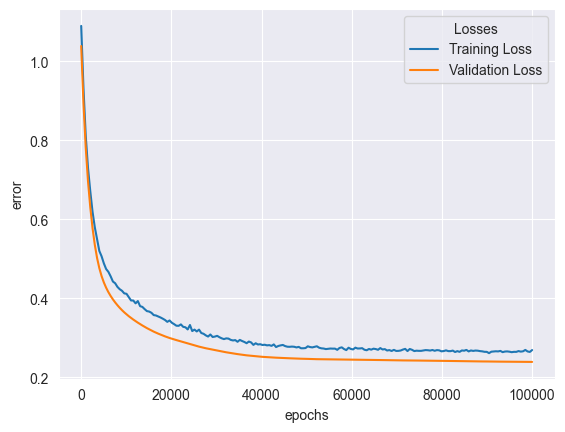

In [33]:
import seaborn as sns
sns.set_style('darkgrid')
data = pd.DataFrame({"epochs" : np.linspace(0,100000, 200), "Training Loss" : train_loss, "Validation Loss" : val_loss})
sns.lineplot(x='epochs', y='error', hue='Losses', data=pd.melt(data, ['epochs'], value_name='error', var_name='Losses'))

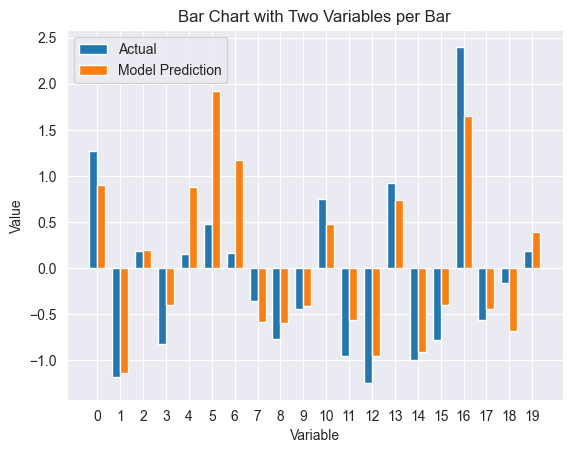

In [32]:
# testing model
model.eval()

# Define the data
labels = range(20)
variable1 = y_test[:20]
with torch.no_grad():
    variable2 = model(x_test_t)[:20].squeeze()
    
variable1 = variable1.squeeze()

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x_pos = [i for i, _ in enumerate(labels)]

# Create the bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x_pos, variable1, bar_width, label='Actual')
rects2 = ax.bar([i + bar_width for i in x_pos], variable2, bar_width, label='Model Prediction')

# Add some text for labels, title, and axes ticks
ax.set_ylabel('Value')
ax.set_xlabel('Variable')
ax.set_title('Bar Chart with Two Variables per Bar')
ax.set_xticks([i + bar_width / 2 for i in x_pos])
ax.set_xticklabels(labels)

# Add a legend
ax.legend()

# Show the plot
plt.show()